In [1]:
from captcha.image import ImageCaptcha
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, matthews_corrcoef

import matplotlib.pyplot as plt
import math
import scipy
%matplotlib inline

In [2]:
lmap=lambda func,it: list(map(lambda x:func(x),it))

# CNN

# Generate Data

In [3]:
def create_random_image():
    img = Image.new(mode='1', size=(16,16),color=188)
    draw=ImageDraw.Draw(img)
    x_axis=np.random.randint(0,6)
    y_axis=np.random.randint(0,6)
    num=np.random.randint(0,10)
    draw.text((x_axis,y_axis), str(num))
    return np.array(img.convert('1')).astype(np.float32), num

In [4]:
img = Image.new(mode='1', size=(16,16),color=188)
draw=ImageDraw.Draw(img)
x_axis=np.random.randint(0,6)
y_axis=np.random.randint(0,6)
num=np.random.randint(0,10)
draw.text((x_axis,y_axis), str(num))
img

In [5]:
samples=[ create_random_image() for _ in range(5000)]

In [6]:
# samples: (image, label)
X=np.array(lmap(lambda x:x[0],samples))
y=np.array(lmap(lambda x:x[1],samples))

# Build Net

In [7]:
class CNN(nn.Module):
    def __init__(self, d_h, d_w, dp=0.5): # 50% percent of cells will be drop out
        super(CNN, self).__init__()
        self.cnn_1=nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1)
        self.mx_pool_1=nn.MaxPool2d(kernel_size=3,stride=1)
        self.cnn_2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.mx_pool_2=nn.MaxPool2d(kernel_size=3,stride=1)
        self.cnn_3=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1)
        self.mx_pool_3=nn.MaxPool2d(kernel_size=3,stride=1)
        self.fc_1=nn.Linear(in_features=128*4*4,out_features=256)
        self.fc_2=nn.Linear(in_features=256,out_features=10)
        self.dropout=nn.Dropout(p=dp)
        
    def forward(self, x):
        out=self.dropout(self.mx_pool_1(F.relu(self.cnn_1(x))))
        out=self.dropout(self.mx_pool_2(F.relu(self.cnn_2(out))))
        out=self.dropout(self.mx_pool_3(F.relu(self.cnn_3(out))))
        out=out.view((out.size(0),-1))
        out=self.dropout(F.relu(self.fc_1(out)))
        out=self.fc_2(out)
        return out

# Build Classifier

In [8]:
class Classifier(object):
    
    def __init__(self, model, dp=0.5,lr=1e-3):
        super(Classifier, self).__init__()
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_func = nn.CrossEntropyLoss()
        
    def train(self, X, y):
        x = torch.tensor(X[:,None,:,:], dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        self.model.train(True)
        self.optimizer.zero_grad()
        y_hat= self.model(x)
        loss=self.loss_func(y_hat,y)
        loss.backward()
        self.optimizer.step()
        y_hat = y_hat.topk(1)[1].detach()
        return loss.item(), y_hat.numpy().flatten()

    def test(self, X, y):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X[:,None, :, :], dtype=torch.float32) # [batch, channal, width, height]
            y = torch.tensor(y, dtype=torch.long)
            
            y_hat= self.model(x)
            loss=self.loss_func(y_hat,y)
            y_hat = y_hat.topk(1)[1].detach()
            return loss.item(), y_hat.numpy().flatten()

    def inference(self, X):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X[:,None,:,:], dtype=torch.float32)
            y_hat= self.model(x)
            y_hat = y_hat.topk(1)[1].detach()
            return y_hat.numpy().flatten()

    def load_model(self, model_path):
        self.model = torch.load(model_path)

    def save_model(self, model_path):
        torch.save(self.model, model_path)

# Train & Test

In [9]:
cnn=CNN(d_h=16,d_w=16)

In [10]:
clf=Classifier(model=cnn)

In [11]:
X_train,y_train=X[:4500],y[:4500]
X_test,y_test=X[4500:],y[4500:]

In [12]:
batch_size=128

In [13]:
for e in range(5):
    i=0
    # train
    while i<X_train.shape[0]:
        batch_x=X_train[i:i+batch_size]
        batch_y=y_train[i:i+batch_size]
        loss,y_hat=clf.train(batch_x,batch_y)
        i+=batch_size
        if i % 1024 ==0:
            print(f'batch loss @ {i}-{e}: {loss}')
    # test
    loss,y_hat=clf.test(X_test,y_test)
    print(f'test loss: {loss}, test acc @{e}: {accuracy_score(y_pred=y_hat.flatten(),y_true=y_test.flatten())}')
    

batch loss @ 1024-0: 2.3349709510803223
batch loss @ 2048-0: 2.008659601211548
batch loss @ 3072-0: 1.7149832248687744
batch loss @ 4096-0: 1.5505292415618896
test loss: 1.303561806678772, test acc @0: 0.768
batch loss @ 1024-1: 1.3072396516799927
batch loss @ 2048-1: 1.0036965608596802
batch loss @ 3072-1: 0.7387285828590393
batch loss @ 4096-1: 0.6375536322593689
test loss: 0.5157903432846069, test acc @1: 0.99
batch loss @ 1024-2: 0.5097836852073669
batch loss @ 2048-2: 0.43311288952827454
batch loss @ 3072-2: 0.32188403606414795
batch loss @ 4096-2: 0.30402863025665283
test loss: 0.23700404167175293, test acc @2: 1.0
batch loss @ 1024-3: 0.2414715588092804
batch loss @ 2048-3: 0.2267918735742569
batch loss @ 3072-3: 0.1790241152048111
batch loss @ 4096-3: 0.1787109076976776
test loss: 0.130181685090065, test acc @3: 1.0
batch loss @ 1024-4: 0.15667974948883057
batch loss @ 2048-4: 0.14560161530971527
batch loss @ 3072-4: 0.10983389616012573
batch loss @ 4096-4: 0.10412361472845078


---

# RNN

# Generate Data

In [14]:
x=np.linspace(0,10,2000)
sin_x=scipy.sin(x*scipy.pi*5)+x/10
# cos_x=scipy.cos(x*scipy.pi*2)
sample=sin_x

In [15]:
X=sample[:-1]
y=sample[1:]

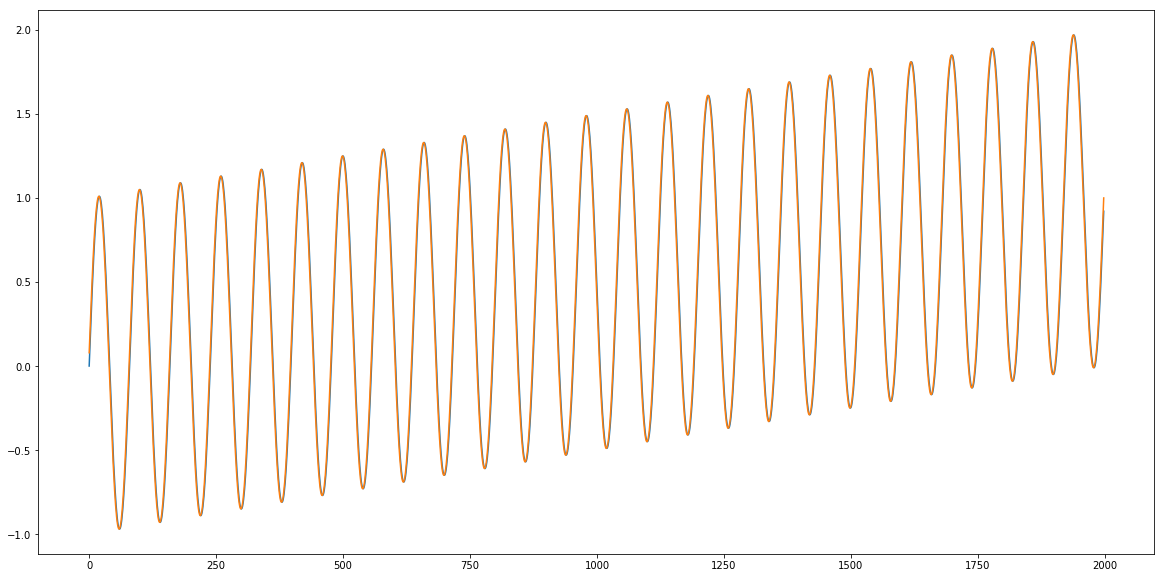

In [16]:
plt.figure(figsize=(20,10))
plt.plot(X)
plt.plot(y)

# Build Net for auto regressive (Stock prediction simulation)

$y_t,h_t=f(y_{t-1},h_{t-1})$

In [17]:
class RNN(nn.Module):
    def __init__(self, d_x, d_h, d_o, dp=0.5):
        super(RNN, self).__init__()
        self.rnn_cell=nn.LSTM(input_size=d_x,hidden_size=d_h,batch_first=True,num_layers=3) # TODO
        self.fc_1 = nn.Linear(d_h,d_h)
        self.fc_out = nn.Linear(d_h,d_o)
        self.dropout=nn.Dropout(p=dp)
        self.d_h=d_h
        
    def forward(self, x, hidden=None):
        out,hidden=self.rnn_cell(x,hidden)
        out=self.dropout(F.relu(self.fc_1(F.tanh(out))))
        out=self.dropout(self.fc_out(out))
        out=out.view(-1)
        return out, hidden # (h, (h, c)) -> h: hidden information to next cell

In [18]:
class Estimator(object):
    def __init__(self, model, dp=0.5,lr=1e-3):
        super(Estimator, self).__init__()
        self.model = model
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=lr)
        self.loss_func = nn.MSELoss()
        self.tmp_hidden=None
        
    def train(self, X, y):
        self.optimizer.zero_grad()
        x = torch.tensor(X[None,:,None], dtype=torch.float32) # [Layer, ] TODO
        y = torch.tensor(y, dtype=torch.float32)
        self.model.train(True)
        y_hat, self.tmp_hidden= self.model(x,self.tmp_hidden)
        y_hat=y_hat.view(-1)
        loss=self.loss_func(y_hat,y)
        loss.backward()
        self.optimizer.step()
        self.tmp_hidden=tuple([h.detach() for h in self.tmp_hidden]) # for LSTM: TODO
#         self.tmp_hidden=self.tmp_hidden.detach() # for 
        return loss.item(), y_hat.detach().numpy()

    def test(self, X, y):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X[None,:,None], dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            y_hat, self.tmp_hidden= self.model(x,self.tmp_hidden)
            y_hat=y_hat.view(-1)
            loss=self.loss_func(y_hat,y)
            return loss.item(), y_hat.numpy()
    
    def inference(self, X):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(X[None,:,None], dtype=torch.float32)
            y_hat, self.tmp_hidden= self.model(x,self.tmp_hidden)
            y_hat=y_hat.view(-1)
            return y_hat.numpy()
    
    def reset_model(self):
        self.tmp_hidden=None
    
    def load_model(self, model_path):
        self.model = torch.load(model_path)

    def save_model(self, model_path):
        torch.save(self.model, model_path)

# Train & Test

In [19]:
X_train,y_train=X[:1800],y[:1800]
X_test,y_test=X[1800:],y[1800:]

In [20]:
rnn=RNN(d_x=1,d_h=256,d_o=1)

In [21]:
est=Estimator(model=rnn)

In [22]:
batch_size=128

In [23]:
for e in range(10):
    i=0
    est.reset_model()
#     train
    while i<X_train.shape[0]:
        batch_x=X_train[i:i+batch_size]
        batch_y=y_train[i:i+batch_size]
        loss,y_hat=est.train(batch_x,batch_y)
        i+=batch_size
        if i % 512 ==0:
            print(f'batch loss @ {i}-{e}: {loss}')
    # test
    loss,y_hat=est.test(X_test,y_test)
    print(f'test loss: {loss}, test mse @{e}: {np.mean((y_hat-y_test)**2)}')
    

/Users/leo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


batch loss @ 512-0: 0.5692627429962158
batch loss @ 1024-0: 0.45012301206588745
batch loss @ 1536-0: 0.5927539467811584
test loss: 0.6028647422790527, test mse @0: 0.6028647127971167
batch loss @ 512-1: 0.4756598174571991
batch loss @ 1024-1: 0.4451709985733032
batch loss @ 1536-1: 0.6097820997238159
test loss: 0.4838396906852722, test mse @1: 0.4838396998495376
batch loss @ 512-2: 0.3958408534526825
batch loss @ 1024-2: 0.4178151786327362
batch loss @ 1536-2: 0.5445443391799927
test loss: 0.3957032263278961, test mse @2: 0.3957032324641235
batch loss @ 512-3: 0.39967259764671326
batch loss @ 1024-3: 0.32766199111938477
batch loss @ 1536-3: 0.4401157796382904
test loss: 0.2774085998535156, test mse @3: 0.2774085940066295
batch loss @ 512-4: 0.3394971489906311
batch loss @ 1024-4: 0.37778741121292114
batch loss @ 1536-4: 0.4529881477355957
test loss: 0.28741201758384705, test mse @4: 0.28741201240544073
batch loss @ 512-5: 0.3899628520011902
batch loss @ 1024-5: 0.33797144889831543
batc

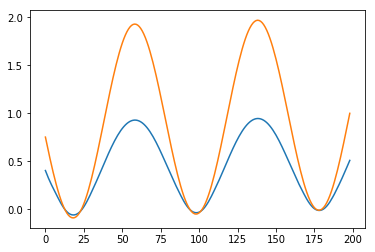

In [24]:
plt.plot(y_hat)
plt.plot(y_test)

# Inference

In [25]:
est.reset_model()
y_hat=np.array([0])
sensor=[]
for i in range(30):
    y_hat=est.inference(y_hat)
    sensor.append(y_hat)

/Users/leo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


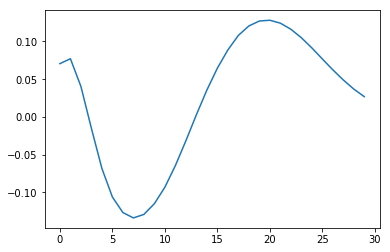

In [26]:
plt.plot(np.array(sensor))